TRAIN_DIR: C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\train224
TEST_DIR : C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\test224
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']


TRAIN_DIR: C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\train224
TEST_DIR : C:\Users\lenovo\OneDrive\Bureau\Cycle 2\S1\Deep Learning\Projet\FaceMaskDataset\FaceMaskDataset\test224
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 4756 files for training.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 5944 files belonging to 2 classes.
Using 1188 files for validation.
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']
Found 3060 files belonging to 2 classes.
Classes : ['face', 'maskface']


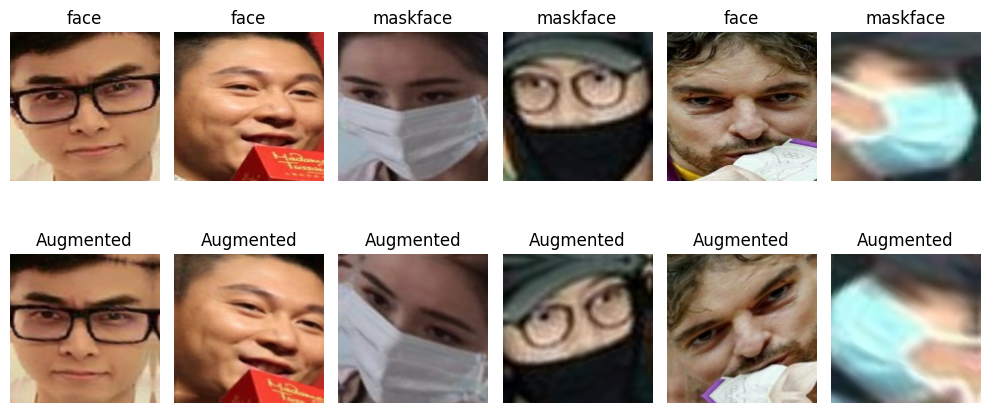

In [1]:
from load import load_data

train_ds, val_ds, test_ds, class_names, data_augmentation, IMG_SIZE, BATCH_SIZE = load_data(show_examples=True)

###  – Modèle 5 (ResNet50 fine-tuning) : Construction de l’architecture

Dans cette cellule, on construit un modèle basé sur **ResNet50 pré-entraîné sur ImageNet**, en appliquant un **fine-tuning partiel** sur les derniers blocs résiduels pour adapter le réseau à la tâche *face / maskface*.

---

### 🔹 1. Backbone ResNet50 pré-entraîné

- `ResNet50(weights="imagenet", include_top=False)`  
  → On utilise uniquement les couches convolutionnelles du modèle (pas la tête dense d’ImageNet).

- Toutes les couches sont d’abord **gelées**, puis on **débloque uniquement les blocs conv5** :
  - ces blocs contiennent les features les plus spécifiques et discriminantes,
  - fine-tuning ciblé = adaptation efficace sans casser les connaissances pré-entraînées.

 **Objectif :**  
Exploiter la puissance de ResNet (skip connections, extraction profonde de features) tout en limitant le sur-apprentissage.

---

### 🔹 2. Prétraitement de l’entrée

- `data_augmentation` : rotations, flips… pour enrichir les données.
- `keras.applications.resnet50.preprocess_input` :  
  → Normalisation spécifique attendue par ResNet50 (centering + scaling).

- `training=False` dans `base_model_resnet(...)`  
  → Les BatchNorm internes restent en mode inférence pour éviter les instabilités du fine-tuning.

---

### 🔹 3. Tête de classification personnalisée

Après la sortie de ResNet50 :

- **GlobalAveragePooling2D**  
  → Transforme les cartes de features en un vecteur compact, sans ajouter beaucoup de paramètres.

- **Dense(512, relu) + L2 + BatchNorm + Dropout(0.5)**  
  → Grande couche fully-connected régulière pour apprendre les caractéristiques spécifiques du masque.

- **Dense(128, relu) + L2 + Dropout(0.3)**  
  → Deuxième couche dense plus légère pour affiner la séparation.

- **Dense(1, sigmoid)**  
  → Sortie binaire : probabilité d’être dans la classe *maskface*.

Cette tête dense apporte :  
- robustesse (BatchNorm),  
- contrôle de l’overfitting (Dropout, L2),  
- flexibilité pour bien exploiter les features extraites par ResNet50.

---


👉 C’est une architecture avancée conçue pour atteindre la **meilleure performance globale** parmi tous les modèles testés.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, regularizers

# Base ResNet50
base_model_resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# On gèle toutes les couches d'abord
for layer in base_model_resnet.layers:
    layer.trainable = False

# On débloque seulement les derniers blocs résiduels (conv5)
for layer in base_model_resnet.layers:
    if "conv5_block" in layer.name:
        layer.trainable = True

print("Nombre de couches totales :", len(base_model_resnet.layers))
print("Nombre de couches trainables :", len([l for l in base_model_resnet.layers if l.trainable]))

# Tête de classification
inputs = keras.Input(shape=IMG_SIZE + (3,))

x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)  # Prétraitement spécifique ResNet
x = base_model_resnet(x, training=False)  # training=False pour garder BatchNorm en mode inférence

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(
    512,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(
    128,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model_resnet = keras.Model(inputs, outputs, name="resnet50_finetuned")

model_resnet.summary()

94765736/94765736 [==============================] - 25s 0us/step
Nombre de couches totales : 175
Nombre de couches trainables : 32
Nombre de couches totales : 175
Nombre de couches trainables : 32
Model: "resnet50_finetuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                

## Compilation + callbacks (Modèle 5)

On utilise :
- Adam avec un **learning rate plus petit** (1e-4) pour le fine-tuning
- binary_crossentropy
- accuracy, precision, recall
- sauvegarde du meilleur modèle
- EarlyStopping + ReduceLROnPlateau

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_resnet.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
)

checkpoint_resnet = ModelCheckpoint(
    "models/resnet50_finetuned_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop_resnet = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_resnet = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

## Entraînement du Modèle 5 (ResNet50 fine-tuning)

In [5]:
EPOCHS = 15

history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_resnet, early_stop_resnet, reduce_lr_resnet],
    verbose=1
)

Epoch 1/15
298/298 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.9437 - precision: 0.9416 - recall: 0.9448
Epoch 1: val_loss improved from inf to 0.99313, saving model to models\resnet50_finetuned_best.h5

Epoch 1: val_loss improved from inf to 0.99313, saving model to models\resnet50_finetuned_best.h5
298/298 [==============================] - 84s 219ms/step - loss: 0.2602 - accuracy: 0.9437 - precision: 0.9416 - recall: 0.9448 - val_loss: 0.9931 - val_accuracy: 0.8182 - val_precision: 0.7407 - val_recall: 0.9984 - lr: 1.0000e-04
Epoch 2/15
298/298 [==============================] - 84s 219ms/step - loss: 0.2602 - accuracy: 0.9437 - precision: 0.9416 - recall: 0.9448 - val_loss: 0.9931 - val_accuracy: 0.8182 - val_precision: 0.7407 - val_recall: 0.9984 - lr: 1.0000e-04
Epoch 2/15
298/298 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9718 - precision: 0.9777 - recall: 0.9652
Epoch 2: val_loss improved from 0.99313 to 0.31338, saving m

## Courbes Loss & Accuracy (Modèle 5)

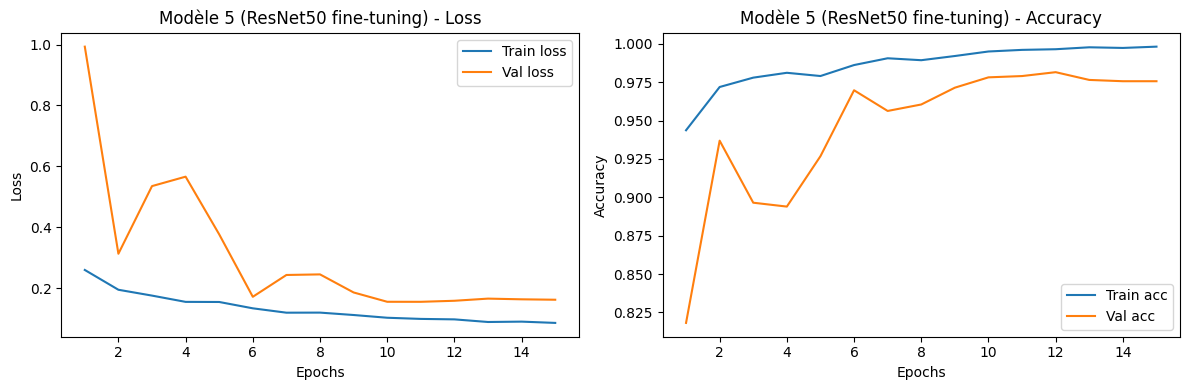

In [6]:
from load import plot_history
plot_history(history_resnet, title_prefix="Modèle 5 (ResNet50 fine-tuning)")

## Évaluation sur le test (Modèle 5)

In [7]:
test_results_resnet = model_resnet.evaluate(test_ds, verbose=1)

print("\nRésultats Modèle 5 (ResNet50 fine-tuning) :")
for name, value in zip(model_resnet.metrics_names, test_results_resnet):
    print(f"{name}: {value:.4f}")

192/192 [==============================] - 14s 73ms/step - loss: 0.1946 - accuracy: 0.9690 - precision: 0.9421 - recall: 0.9683

Résultats Modèle 5 (ResNet50 fine-tuning) :
loss: 0.1946
accuracy: 0.9690
precision: 0.9421
recall: 0.9683
192/192 [==============================] - 14s 73ms/step - loss: 0.1946 - accuracy: 0.9690 - precision: 0.9421 - recall: 0.9683

Résultats Modèle 5 (ResNet50 fine-tuning) :
loss: 0.1946
accuracy: 0.9690
precision: 0.9421
recall: 0.9683


## Matrice de confusion et rapport de classification (Modèle 5)

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
for _, labels in test_ds:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true, axis=0)

y_pred_proba = model_resnet.predict(test_ds)
y_pred = (y_pred_proba.ravel() > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

192/192 [==============================] - 12s 59ms/step
Confusion Matrix:
 [[1957   62]
 [  33 1008]]

Classification Report:
              precision    recall  f1-score   support

        face       0.98      0.97      0.98      2019
    maskface       0.94      0.97      0.95      1041

    accuracy                           0.97      3060
   macro avg       0.96      0.97      0.97      3060
weighted avg       0.97      0.97      0.97      3060

Confusion Matrix:
 [[1957   62]
 [  33 1008]]

Classification Report:
              precision    recall  f1-score   support

        face       0.98      0.97      0.98      2019
    maskface       0.94      0.97      0.95      1041

    accuracy                           0.97      3060
   macro avg       0.96      0.97      0.97      3060
weighted avg       0.97      0.97      0.97      3060



### Modèle 5 – ResNet50 fine-tuning (interprétation des courbes et résultats)

#### 1) Lecture des courbes Loss

- **Train loss** : diminue rapidement puis continue à baisser de façon régulière → le modèle apprend bien sans instabilité.
- **Val loss** : très haute au début (adaptation du fine-tuning), puis chute fortement et se stabilise autour de ~0.16–0.18.
- Les deux courbes restent **proches** en fin d’entraînement → pas d’overfitting important.

#### 2) Lecture des courbes Accuracy

- **Train accuracy** : part déjà haut (~0.95) et monte presque jusqu’à **1.0**.
- **Val accuracy** : progresse vite après les premiers epochs et se stabilise autour de **0.97–0.98**.
- La validation suit bien l’entraînement, avec seulement de petites oscillations normales.

👉 Les courbes montrent un **fine-tuning efficace et stable** : le backbone ResNet50 + tête dense est bien adapté aux données.

#### 3) Résultats sur le test

- `loss = 0.1946`
- `accuracy = 0.9690`
- `precision = 0.9421`
- `recall = 0.9683`

**Rapport par classe :**

- `face` : precision = 0.98, recall = 0.97, f1 = 0.98  
- `maskface` : precision = 0.94, recall = 0.97, f1 = 0.95  

**Matrice de confusion :**

- TN (face → face) = 1957  
- FP (face → maskface) = 62  
- FN (maskface → face) = 33  
- TP (maskface → maskface) = 1008  

→ Très peu d’erreurs, aussi bien sur les visages avec que sans masque.

#### 4) Conclusion

- Le ResNet50 fine-tuné est **le meilleur modèle** parmi tous :
  - meilleure accuracy globale (~97 %),
  - f1-scores très élevés sur les deux classes,
  - courbes train/val stables.
- Il combine la puissance d’un backbone profond pré-entraîné + un fine-tuning ciblé des derniers blocs conv5.
